# Chapitre 6 - Différentes utilisations du machine learning avec Python (1ère partie)

## 6. 4 L’apprentissage supervisé avec Scikit-Learn

Les méthodes d’apprentissage supervisé sont les méthodes actuellement les plus
utilisées en data science. Il s’agit d’essayer de prédire une variable cible et d’utiliser
différentes méthodes pour arriver à cette fin.
Nous allons illustrer ces méthodes de traitement de données avec du code et des
cas pratiques.
### 6.4.1 Les données et leur transformation

Ce jeu de données est décrit en détail au début du chapitre 4. Pour rappel, il est composé de 3333 individus et de 18 variables. Il est stocké dans un fichier csv, nommé telecom.csv, accessible dans le répertoire Data. On le récupère en utilisant Pandas :

In [1]:
import pandas as pd
import numpy as np

In [2]:
churn=pd.read_csv("../data/telecom.csv")

Ce jeu de données n’a pas de données manquantes et nous allons devoir effectuer
quelques transformations pour l’adapter à nos traitements. Nous voyons par exemple qu’il est composé de trois colonnes object.

Nous pouvons afficher les statistiques descriptives pour les colonnes object :

In [3]:
churn.describe(include="object").transpose()

,count,unique,top,freq
State,3333,51,WV,106
Phone,3333,3333,382-4657,1
Int'l Plan,3333,2,no,3010
VMail Plan,3333,2,no,2411
Churn?,3333,2,False.,2850


On voit que les données sont toutes binaires. 

Pour les variables binaires, il nous suffit de les recoder avec Scikit-Learn pour obtenir des données exploitables. Par
ailleurs, il existe une autre variable qualitative dans notre jeu de données, Area Code,
qui est numérique mais avec trois modalités :

In [4]:
churn["Area Code"].value_counts()

Area Code
415    1655
510     840
408     838
Name: count, dtype: int64

#### La préparation des données

Nous allons utiliser le processus de traitement classique pour transformer nos
données avec Scikit-Learn. Dans ce cas, nous n’avons pas de données manquantes,
nous travaillons donc sur la transformation des variables qualitatives.

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

LabelEncoder va nous permettre de transformer les valeurs textuelles en entiers.
Nous pouvons utiliser pour chaque variable qualitative :

In [6]:
encoder = LabelEncoder()
churn["Churn?"] = encoder.fit_transform(churn["Churn?"])

In [7]:
dict_label_encode={}
for col in churn.columns:
    if churn[col].dtype == object:
        dict_label_encode[col]=LabelEncoder()
        churn[col]=dict_label_encode[col].fit_transform(churn[col])

Nous utilisons la classe OneHotEncoder afin de transformer la colonne Area Code
en trois colonnes binaires (le chapitre 4 détaille le fonctionnement de cet outil) :

In [8]:
# on définit l’objet
encoder_area=OneHotEncoder(sparse_output=False,categories="auto")

# on crée un array dans lequel on stocke le résultat
area=encoder_area.fit_transform(np.array(churn["Area Code"]).reshape(-1, 1))

# on définit un DataFrame nettoyé qui consiste en la concaténation du
# DataFrame initial et des nouvelles colonnes
churn_clean=pd.concat([churn, pd.DataFrame(area,
                                           columns=encoder_area.categories_,
                                           index=churn.index)], axis=1)
# on supprime la colonne initiale
churn_clean.drop("Area Code", axis=1, inplace=True)

In [9]:
churn_clean

,State,Account Length,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,...,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?,"(408,)","(415,)","(510,)"
0,16,128,1926,0,1,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,0,0.0,1.0,0.0
1,35,107,1575,0,1,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,0.0,1.0,0.0
2,31,137,1117,0,0,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,0.0,1.0,0.0
3,35,84,1707,1,0,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,1.0,0.0,0.0
4,36,75,110,1,0,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,3057,0,1,36,156.2,77,26.55,215.5,...,83,12.56,9.9,6,2.67,2,0,0.0,1.0,0.0
3329,49,68,1528,0,0,0,231.1,57,39.29,153.4,...,123,8.61,9.6,4,2.59,3,0,0.0,1.0,0.0
3330,39,28,42,0,0,0,180.8,109,30.74,288.8,...,91,8.64,14.1,6,3.81,2,0,0.0,0.0,1.0
3331,6,184,1331,1,0,0,213.8,105,36.35,159.6,...,137,6.26,5.0,10,1.35,2,0,0.0,0.0,1.0


In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 

In [11]:
# nous stockons d'abord le nom des colonnes quantitatives
numeric_features = [ 'VMail Message','Day Mins', 
                    'Day Calls', 'Day Charge',
                    'Eve Mins', 'Eve Calls', 
                    'Eve Charge', 'Night Mins', 
                    'Night Calls','Night Charge', 
                    'Intl Mins', 'Intl Calls',
                    'Intl Charge','CustServ Calls']
# nous appliquons à ces colonnes une transformation
numeric_transformer = StandardScaler()

# nous stockons d'abord le nom des colonnes qualitatives
categorical_features = ['Area Code', 
                        "Int'l Plan",
                        'VMail Plan']
# nous appliquons à ces colonnes une OneHot
categorical_transformer = OneHotEncoder(handle_unknown='ignore',
                                        categories='auto',)

# on combine toutes ces informations dans un objet de la
# classe ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)]
)

In [12]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [13]:
# on applique les transformations sur toutes les colonnes
churn_clean = preprocessor.fit_transform(churn)

#### Prédire l’attrition des clients
Lorsqu’on veut prédire une variable binaire, on devra avoir une colonne du type
binaire. On préfère généralement un codage 0/1 afin de garder un type entier simple à gérer. 

Les variables explicatives x auront été préparées de manière intelligente afin de bien appliquer nos modèles.

On crée donc x et y :

In [14]:
x = churn_clean
y = churn["Churn?"]


Pour la séparation, on utilise la fonction train_test_split() de Scikit-Learn.

Cette fonction permet de créer automatiquement autant de structures que nécessaire
à partir de nos données. 

Elle utilise une randomisation des individus et ensuite une séparation en fonction d’un paramètre du type test_size :

In [15]:
# on importe la fonction
from sklearn.model_selection import train_test_split

# dans ce cas on a :
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)


Dans certains cas, il peut arriver qu’il y ait une forte disparité de distribution des
modalités entre les proportions d’acceptation et de refus. On peut vouloir faire en
sorte que les répartitions des modalités de y soient égales dans les différents échantillons,
on pourra alors utiliser une stratification. On va utiliser une stratification en
prenant y comme base pour effectuer la stratification :

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify = y)
y.value_counts(normalize=True)

Churn?
0    0.855086
1    0.144914
Name: proportion, dtype: float64

Ainsi les deux échantillons _train et _test ont la même distribution

In [17]:
y_test.value_counts(normalize=True)

Churn?
0    0.855
1    0.145
Name: proportion, dtype: float64

In [18]:
y_train.value_counts(normalize=True)

Churn?
0    0.855122
1    0.144878
Name: proportion, dtype: float64

#### Les données déséquilibrées
Ce problème se pose souvent lorsque vous cherchez à identifier des évènements
rares, notamment la recherche de fraudes. Dans ce cas, la variable cible y a souvent
moins de 1 % d’une des deux modalités.

In [19]:
from imblearn.under_sampling import NearMiss

In [20]:
ss_echant = NearMiss()

In [21]:
# on applique la méthode fit_resample() sur nos données
x_sous, y_sous= ss_echant.fit_resample(x_train, y_train)
# on le transforme en Series pour avoir un affichage psl uagréable
pd.Series(y_sous).value_counts()

Churn?
0    338
1    338
Name: count, dtype: int64

On voit donc que le nombre de 1 (classe minoritaire) n’a pas changé.
Cette étape permet d’obtenir des données x construites de manière à bien différencier
les individus.
Pour le sur-échantillonnage, l’algorithme SMOTE (Synthetic Minority Oversampling
Technique) fait référence. Cet algorithme va permettre de créer des individus proches
de ceux de la classe minoritaire afin de sur-représenter cette classe :

In [22]:
from imblearn.over_sampling import SMOTE
sur_echant=SMOTE()
# on applique la méthode fit_resample() sur nos données
x_sur, y_sur= sur_echant.fit_resample(x_train, y_train)
# on le transforme en Series pour avoir un affichage psl uagréable
pd.Series(y_sur).value_counts()

Churn?
1    1995
0    1995
Name: count, dtype: int64

On voit ici que le nombre d’individus de la classe majoritaire reste le même.
Ce package propose aussi une approche intermédiaire qui va combiner du souséchantillonnage
et du sur-échantillonnage, et qui s’adapte bien, soit lorsque le jeu
de données global est très grand, soit quand la classe sous-représentée a très peu
d’occurrences. On utilise une combinaison de SMOTE et de plus proches voisins :

In [23]:
from imblearn.combine import SMOTEENN
comb_echant=SMOTEENN()

In [24]:
# on applique la méthode fit_resample() sur nos données
x_comb, y_comb= comb_echant.fit_resample(x_train, y_train)
# on le transforme en Series pour avoir un affichage plus agréable
pd.Series(y_comb).value_counts()

Churn?
1    1956
0    1422
Name: count, dtype: int64

On voit qu’on arrive à un jeu de données intermédiaire.
L’approche à privilégier dépendra de vos données. Dans le cadre de notre exemple,
nous allons garder la répartition actuelle afin d’illustrer la suite.
Nous avons donc quatre jeux de données prêts à être utilisés pour nos traitements.
L’étape suivante est le choix de l’algorithme de machine learning.

### 6.4.2 Le choix et l’ajustement de l’algorithme

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Ensuite, on crée un objet à partir de la classe du modèle en lui fournissant les
hyperparamètres dont il a besoin :

In [26]:
modele_rf=RandomForestClassifier()
modele_knn=KNeighborsClassifier()

Dans ce cas, on prend les hyperparamètres par défaut.

On peut ensuite ajuster notre modèle en utilisant les données :

In [27]:
modele_rf.fit(x_train,y_train)
modele_knn.fit(x_train,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Une fois qu’on a estimé les paramètres du modèle, on va pouvoir extraire des
informations. De nouveaux attributs de chaque classe apparaissent, ils se terminent par le symbole underscore _ :

In [28]:
modele_rf.feature_importances_

array([0.02036629, 0.13696217, 0.03727796, 0.14711541, 0.06912264,
       0.0311089 , 0.06492417, 0.04051002, 0.03316072, 0.03899316,
       0.04810238, 0.05044279, 0.04447404, 0.11602939, 0.00472568,
       0.00532458, 0.00403459, 0.03834157, 0.04095875, 0.01510612,
       0.01291869])

Ce qui va nous intéresse avant tout, c’est de prédire avec notre modèle. Pour cela nous allons utiliser la méthode .predict() :

In [29]:
y_predict_rf = modele_rf.predict(x_test)
y_predict_knn = modele_knn.predict(x_test)

On obtient ainsi une valeur prédite pour les éléments de notre échantillon de
validation.

### Cas d’un modèle de régression

Sur les données des territoires d’Ile-de-France, nous désirons prédire le salaire
médian des communes en fonction des autres variables des données. 

In [30]:
from sklearn.linear_model import Ridge

In [31]:
data=pd.read_csv("../data/base-comparateur-de-territoires.csv",sep=";").dropna()
# on prépare les données
y_quanti=data["MED14"]
x_quanti=data.select_dtypes(np.number).drop(["CODGEO","REG","DEP","MED14"],axis=1)

In [32]:
# on sépare les échantillons apprentissage
x_train_cont, x_test_cont, y_train_cont, y_test_cont = train_test_split(x_quanti,
                                                                        y_quanti,
                                                                        test_size=0.3)

# on utilise un modèle de régression de Ridge
modele_ridge = Ridge()

# on ajuste le modèle aux données
modele_ridge.fit(x_train_cont, y_train_cont)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [33]:
# on peut afficher les coefficients du modèle :
modele_ridge.coef_

array([ 7.02957717e-01,  2.04735728e-02,  9.83347682e+00,  4.82604818e-01,
        2.60861829e+00,  1.31486544e-01, -1.75442131e+00, -1.43240346e+01,
        2.87811205e-02,  1.31480118e-01,  2.02494627e-01, -3.04182631e-01,
       -1.34413786e-01, -6.68207762e-01,  5.05959153e+02,  1.80933245e+02,
       -4.92110332e-01,  6.22834724e-01, -4.25432156e-02, -1.03798081e+00,
       -3.66732818e-01,  2.16742097e-01,  4.18674813e-02, -7.12705878e+00,
        6.30315616e+00, -2.38338027e+00,  3.42920191e-01,  1.28424649e+00,
        2.90623386e+00,  3.51919760e-01, -8.81595513e+00])

In [34]:
# on prédit grâce à ce modèle
y_predict_cont=modele_ridge.predict(x_test_cont)

### 6.4.3 Les indicateurs pour valider un modèle
La partie validation d’un modèle d’apprentissage supervisé est extrêmement
importante. L’objectif d’un modèle d’apprentissage supervisé est de prédire une
valeur la plus proche possible de la réalité. Nous différencions trois types d’indices
en fonction du type de variable cible. Tous les indicateurs de qualité du modèle sont
stockés dans le module *metrics* de Scikit-Learn.

#### Le pourcentage de bien classés
Il s’agit de l’indicateur le plus connu. On le nomme accuracy. Il est calculé à partir du rapport entre le nombre d’individus bien classés et le nombre total d’individus dans l’échantillon.

In [35]:
from sklearn.metrics import accuracy_score
accuracy_modele_rf=accuracy_score(y_test,y_predict_rf)
accuracy_modele_knn=accuracy_score(y_test,y_predict_knn)
print("Pourcentage de bien classés pour le modèle RF :",accuracy_modele_rf)
print("Pourcentage de bien classés pour le modèle kNN :",accuracy_modele_knn)

Pourcentage de bien classés pour le modèle RF : 0.955
Pourcentage de bien classés pour le modèle kNN : 0.896


#### La matrice de confusion
Il s’agit d’un autre indicateur important pour juger de la qualité d’un modèle, il n’est pas défini par une seule valeur mais par une matrice dans laquelle on peut lire le croisement entre les valeurs observées et les valeurs prédites à partir du modèle. 

Pour calculer cette matrice, on pourra utiliser :

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix_rf=confusion_matrix(y_test,y_predict_rf)
confusion_matrix_knn=confusion_matrix(y_test,y_predict_knn)
print("Matrice de confusion pour le modèle RF :",
confusion_matrix_rf, sep="\n")
print("Matrice de confusion pour le modèle kNN :",
confusion_matrix_knn, sep="\n")

Matrice de confusion pour le modèle RF :
[[845  10]
 [ 35 110]]
Matrice de confusion pour le modèle kNN :
[[848   7]
 [ 97  48]]


#### Le rappel (recall), la précision et le f1-score

Scikit-Learn possède des fonctions pour chacun de ces indicateurs, mais il peut
être intéressant d’utiliser une autre fonction qui les affiche pour chaque classe :


In [37]:
from sklearn.metrics import classification_report
print("Rapport pour le modèle RF :",
      classification_report(y_test,y_predict_rf) ,sep="\n")
print("Rapport pour le modèle kNN :",
      classification_report(y_test,y_predict_rf) ,sep="\n")

Rapport pour le modèle RF :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       855
           1       0.92      0.76      0.83       145

    accuracy                           0.95      1000
   macro avg       0.94      0.87      0.90      1000
weighted avg       0.95      0.95      0.95      1000

Rapport pour le modèle kNN :
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       855
           1       0.92      0.76      0.83       145

    accuracy                           0.95      1000
   macro avg       0.94      0.87      0.90      1000
weighted avg       0.95      0.95      0.95      1000



#### La courbe ROC
Nous avons vu que lorsque les classes sont fortement déséquilibrées, la matrice
de confusion est parfois dure à interpréter. La courbe ROC (Receiver Operating
Characteristic) est là pour combler ce défaut. Elle est en fait la proportion de vrais positifs en fonction de la proportion de faux positifs.

Il s’agit en fait de représenter le rappel (recall) en fonction de (1- spécificité) sur une courbe en faisant varier le seuil de classification (c’est-à-dire le point à partir duquel une observation est considérée comme positive).

La courbe ROC s’obtient avec Scikit-Learn et Matplotlib :

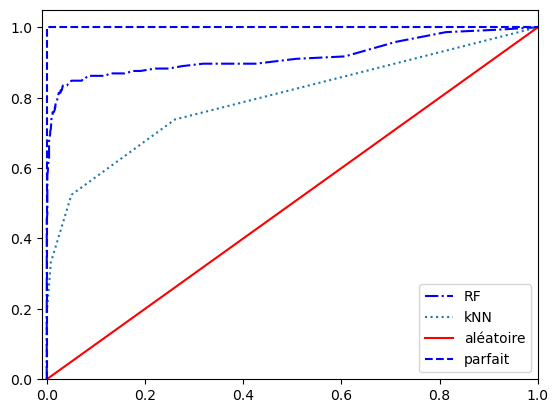

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve

# on extrait les probabilités d'appartenance
proba_rf= modele_rf.predict_proba(x_test)[:,1]
proba_knn=modele_knn.predict_proba(x_test)[:,1]

# cas du modèle RF
fpr, tpr, _ = roc_curve(y_test, proba_rf)
plt.plot(fpr,tpr,"b-.", label="RF")

# cas du modèle kNN
fpr, tpr, _ = roc_curve(y_test, proba_knn)
plt.plot(fpr,tpr,":", label="kNN")

# modèle aléatoire
plt.plot([0, 1], [0, 1],"r-", label="aléatoire", )

# modèle parfait
plt.plot([0,0, 1], [0,1, 1], 'b--', label="parfait")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

#### L’aire sous la courbe ROC
La courbe ROC est un indicateur important mais on préfère souvent une valeur plutôt
qu’une courbe afin de comparer nos modèles. Pour cela, on utilise l’aire sous la courbe
ROC (AUC). Cette aire est calculée directement à partir de la courbe ROC. Ainsi, un
modèle aléatoire aura une AUC de 0.5 et un modèle parfait aura une AUC de 1.

In [39]:
from sklearn.metrics import roc_auc_score
auc_modele_rf=roc_auc_score(y_test, modele_rf.predict_proba(x_test)[:,1])
auc_modele_knn=roc_auc_score(y_test,modele_knn.predict_proba(x_test)[:,1])

print("Aire sous la courbe ROC pour le modèle RF :" ,auc_modele_rf)
print("Aire sous la courbe ROC pour le modèle kNN :" ,auc_modele_knn)

Aire sous la courbe ROC pour le modèle RF : 0.9169913288969549
Aire sous la courbe ROC pour le modèle kNN : 0.7952934059286145


#### La validation croisée
Jusqu’ici nous avons utilisé des indicateurs basés sur une seule occurrence de test. Ceci veut dire qu’on ne teste notre modèle que sur un seul échantillon.

Une approche alternative souvent utilisée est la validation croisée. Celle-ci est en fait basée sur la répétition de l’estimation et de la validation sur des données différentes.

Pour obtenir ce cv-score, on utilise :

In [40]:
from sklearn.model_selection import cross_val_score

scores_rf = cross_val_score(modele_rf, x, y, cv=5, scoring='roc_auc')
scores_knn = cross_val_score(modele_knn, x, y, cv=5, scoring='roc_auc')

print("AUC pour RF : %.2f (+/- %.2f)"% (scores_rf.mean(), scores_knn.std() * 2))
print("AUC pour kNN : %.2f (+/- %.2f)"% (scores_knn.mean(),scores_knn.std() * 2))

AUC pour RF : 0.92 (+/- 0.06)
AUC pour kNN : 0.80 (+/- 0.06)


#### La validation dans le cas continu

Il s’agit du cas où on essaye de prédire une variable quantitative. Dans ce cas, on ne peut pas utiliser les indicateurs précédents

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error

# le R², à la différence des autres scores, est généralmeent
# calculé sur l’échantillon d’apprentissage
print("R2 :",r2_score(y_train_cont,modele_ridge.predict(x_train_cont)))

# les autres indicateurs sont basés sur l’échantillon de validation
print("MCE :",mean_squared_error(y_test_cont,y_predict_cont))
print("RMCE :",np.sqrt(mean_squared_error(y_test_cont,y_predict_cont)))
print("MAE :",median_absolute_error(y_test_cont,y_predict_cont))

R2 : 0.891375822278445
MCE : 3964506.762704513
RMCE : 1991.1069189535033
MAE : 900.430187377915


### 6.4.4 L’ajustement des hyperparamètres d’un modèle

L’une des tâches du data scientist est de trouver le meilleur modèle possible. La
plupart des modèles de machine learning ont des hyperparamètres. Il s’agit de paramètres
du modèle qui sont définis en amont de l’ajustement.

Scikit-Learn propose une classe GridSearchCV permettant d’implémenter cette
recherche d’hyperparamètres :

In [42]:
from sklearn.model_selection import GridSearchCV

On va donc devoir définir les hyperparamètres que l’on souhaite tester. Pour cela,
on utilisera un dictionnaire d’hyperparamètres, par exemple :

In [43]:
dico_param= {"max_depth":[3,5,7,10], "n_estimators":[10,20,50,100]}

On va encore utiliser l’accuracy pour valider notre modèle. Finalement, nous allons
utiliser une validation croisée à cinq groupes pour valider les résultats.
Le nouvel objet est le suivant :

In [44]:
recherche_hyper = GridSearchCV(RandomForestClassifier(), 
                               dico_param, 
                               scoring="accuracy",cv=5)

Une fois qu’on a créé cet objet, on peut lui joindre les données afin d’estimer les
meilleurs paramètres du modèle.

Cette étape peut être très longue.

In [45]:
recherche_hyper.fit(x_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [3, 5, ...], 'n_estimators': [10, 20, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


Si nous revenons à notre exemple de données des télécommunications avec nos
deux estimateurs par forêt aléatoire et par plus proches voisins. Nous allons faire
varier les hyperparamètres de ces deux modèles pour trouver la meilleure combinaison
en termes d’aire sous la courbe ROC :

In [46]:
from sklearn.model_selection import GridSearchCV

# construction des dictionnaires d’hyperparamètres
dico_param_rf={"n_estimators":[10,100,1000],"max_depth":[5,7,9]}
dico_param_knn={"n_neighbors":[2,5,10,50],"weights":['uniform','distance']}

modele_grid_rf=GridSearchCV(modele_rf,dico_param_rf,
                            scoring="roc_auc",cv=5)

modele_grid_knn=GridSearchCV(modele_knn, dico_param_knn,
                             scoring="roc_auc",cv=5)

In [47]:
# estimation des paramètres et des meilleurs modèles
modele_grid_rf.fit(x_train,y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [5, 7, ...], 'n_estimators': [10, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [48]:
# estimation des paramètres et des meilleurs modèles
modele_grid_knn.fit(x_train,y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [2, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,50


In [49]:
# affichage des AUC pour la combinaison obtenant
# les meilleurs résultats
print("Meilleurs paramètres RF:", modele_grid_rf.best_params_)
print("AUC - RF:", modele_grid_rf.best_score_)
print("Meilleurs paramètres kNN:", modele_grid_knn.best_params_)
print("AUC - kNN:", modele_grid_knn.best_score_)

Meilleurs paramètres RF: {'max_depth': 7, 'n_estimators': 100}
AUC - RF: 0.914051590785568
Meilleurs paramètres kNN: {'n_neighbors': 50, 'weights': 'distance'}
AUC - kNN: 0.8656155863759485


On voit que malgré ce travail, les forêts aléatoires sont toujours plus efficaces que
les plus proches voisins.
Si le nombre d’hyperparamètres devient trop grand, on utilise alors une recherche
aléatoire parmi les combinaisons avec la classe RandomSearchCV.

### 6.4.5 La construction d’un pipeline de traitement

Bien souvent vous allez être amené à enchaîner des traitements sur des données.
On peut bien sûr développer son code de manière à suivre les étapes une à une mais il est souvent plus intéressant de créer des suites de traitements automatisées avec Scikit-Learn. 

Ces suites de traitements sont appelées pipeline. Ils simplifieront votre code et permettront de passer en production simplement.

Ainsi, on va pouvoir faire une analyse en composantes principales suivies d’un
algorithme de plus proches voisins directement dans un pipeline :

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [51]:
acp=PCA(n_components=8)
knn=KNeighborsClassifier()
pipe=Pipeline(steps=[("acp",acp),("knn",knn)])
pipe.fit(x_train, y_train)

,steps,"[('acp', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,8
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [52]:
roc_auc_score(y_test,pipe.predict_proba(x_test)[:,1])

0.7444081468037911

On a ainsi enchaîné deux traitements. Si on cherche des sorties liées à chacune
des étapes, on pourra le faire simplement. Par exemple, si l’objectif est d’extraire la part de variances expliquées par les composantes de l’analyse en composantes principales, on fera :

In [53]:
pipe.named_steps["acp"].explained_variance_ratio_

array([0.13738786, 0.13468086, 0.13136427, 0.12383913, 0.08921605,
       0.06957423, 0.06745641, 0.06597809])

#### Trouver la meilleure combinaison d’hyperparamètres dans un pipeline

Essayons de trouver la meilleure combinaison d’hyperparamètres dans un pipeline.
Dans le cadre de cet exemple, nous utiliserons les SVM (support vector machines,
également appelés séparateurs à vaste marge ou machines à vecteurs de support).
Ce sont des méthodes assez complexes dans leur principe mais simples dans leur
mise en oeuvre.

Les hyperparamètres d’un modèle de SVM sont assez nombreux. Les plus importants
étant le noyau choisi (linéaire, polynomial, sigmoïd, RBF…), les paramètres de
ces noyaux (le degré pour le cas polynomiale, gamma…) et le C pour la marge floue.

Dans notre exemple, on utilisera la fonction make_pipeline qui est équivalente
à la classe précédente avec quelques simplifications :

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# construction du pipeline basé sur deux approches
mon_pipe=make_pipeline(PCA(), SVC(probability=True))

# construction du dictionnaire des paramètres
# (attention utilisation de __)
param_grid = dict(pca__n_components=[5, 10, x_train.shape[1]],
                  svc__C= [1, 10, 100, 1000],
                  svc__kernel= ['sigmoid', 'rbf'],
                  svc__gamma= [0.001, 0.0001])

# on construit l’objet GridSearch et on estime les hyper-paramètres
# par validation croisée
grid_search_mon_pipe = GridSearchCV(mon_pipe, param_grid = param_grid, scoring = "roc_auc", cv = 4)

In [55]:
grid_search_mon_pipe.fit(x_train,y_train)

,estimator,Pipeline(step...ility=True))])
,param_grid,"{'pca__n_components': [5, 10, ...], 'svc__C': [1, 10, ...], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['sigmoid', 'rbf']}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,21


In [56]:
# la meilleure combinaisons de paramètres est :
grid_search_mon_pipe.best_params_

{'pca__n_components': 21,
 'svc__C': 1000,
 'svc__gamma': 0.001,
 'svc__kernel': 'rbf'}

Les meilleurs hyperparamètres obtenus en utilisant l’aire sous la courbe ROC sont
la combinaison C = 10, gamma = 0.0001, un noyau RBF pour les SVM et dix composantes
pour notre analyse en composantes principales.

Dans ce code, on définit les hyperparamètres associés à une méthode du pipeline
avec un double underscore : __.

L’utilisation des pipelines de Scikit-Learn va devenir rapidement une étape cruciale
de vos développements en Python.

### 6.4.6 Passer en production votre modèle d’apprentissage supervisé

#### Persistance de modèle avec Scikit-Learn

Python possède plusieurs outils pour la persistance d’objets, c’est-à-dire pour stocker
des objets dans des fichiers. Les objets de Scikit-Learn sont aussi dans cette
situation. On utilise un format pickle qui aura l’extension .pkl.

Par exemple, si nous voulons sauvegarder le dernier pipeline de traitement, nous
allons utiliser :

In [57]:
import joblib
joblib.dump(grid_search_mon_pipe, '../data/modele_grid_pipe.pkl')

['../data/modele_grid_pipe.pkl']

Une fois ce modèle stocké, on peut très bien le réutiliser dans un autre cadre. Si
nous créons un nouveau notebook, nous allons utiliser :



In [58]:
import joblib
grid_search_mon_pipe = joblib.load('../data/modele_grid_pipe.pkl')

On peut ensuite appliquer le modèle avec tous les paramètres qui ont été appris :


L’utilisation d’un fichier Pickle dans un notebook est une technique assez simple et courante.

#### Les risques liés à la production

Le processus de mise en place d’un modèle de machine learning devra intégrer une gestion des versions de code et des versions de modèles. Pour cela, on utilisera, d’une part, un outil comme Git et, d’autre part, un outil comme MLflow. MLflow vous permettra de suivre la mise en place de votre modèle, les différentes itérations du modèle et ses différentes versions.

In [ ]:
# on importe les outils nécessaires
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
import mlflow
import mlflow.sklearn

# on fixe les hyper-paramètres du modèle
alpha =  0.5
l1_ratio =  0.5

# on lance l’utilisation de MLFlow
with mlflow.start_run():
    # on crée le modèle et on lance l’apprentissage et la prédiction
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(x_train, y_train)
    predicted_qualities = lr.predict(x_test)
    # on clacule une métrique
    rmse = np.sqrt(mean_squared_error(y_test, predicted_qualities))
    # on stocke les résultats dans mlFlow
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model(lr, "model", registered_model_name= "ElasticnetWineModel")


L'utilisation de MLFlow participe du ML engineering et doit aujourd'hui être une partie importante du machine learning.